# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [56]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [57]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [58]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-24 09:00:00+09:00,49095.269531,49195.960938,48965.781250,49059.851562,0,0.0,0.0
2025-10-24 09:15:00+09:00,49062.839844,49141.851562,49022.449219,49022.449219,0,0.0,0.0
2025-10-24 09:30:00+09:00,49019.761719,49235.328125,49019.761719,49207.500000,0,0.0,0.0
2025-10-24 09:45:00+09:00,49206.429688,49267.269531,49156.519531,49172.628906,0,0.0,0.0
2025-10-24 10:00:00+09:00,49169.000000,49260.218750,49169.000000,49215.671875,0,0.0,0.0
2025-10-24 10:15:00+09:00,49221.871094,49240.460938,49184.359375,49204.441406,0,0.0,0.0


## 前日終値の取得

In [59]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-17 00:00:00+09:00    47582.148438
2025-10-20 00:00:00+09:00    49185.500000
2025-10-21 00:00:00+09:00    49316.058594
2025-10-22 00:00:00+09:00    49307.789062
2025-10-23 00:00:00+09:00    48641.609375
2025-10-24 00:00:00+09:00    49205.730469
Name: Close, dtype: float64


Date
2025-10-23 00:00:00+09:00    48641.609375
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [60]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

+453.66


## ローソク足チャート（小さいサイズ）

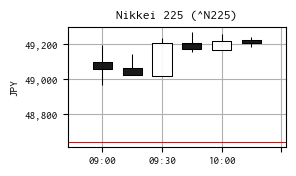

In [61]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose, color="red", linewidth=0.75)
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [62]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [63]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="2d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-23 08:00:00+09:00,151.893997,151.957001,151.893997,151.951996,0,0.0,0.0
2025-10-23 08:15:00+09:00,151.947998,151.960007,151.908005,151.953003,0,0.0,0.0
2025-10-23 08:30:00+09:00,151.951996,151.966995,151.908997,151.955002,0,0.0,0.0
2025-10-23 08:45:00+09:00,151.945999,151.996994,151.923996,151.981003,0,0.0,0.0
2025-10-23 09:00:00+09:00,151.975998,152.164001,151.960999,152.134995,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-24 09:30:00+09:00,152.533997,152.559998,152.464996,152.533005,0,0.0,0.0
2025-10-24 09:45:00+09:00,152.537003,152.664001,152.518997,152.641998,0,0.0,0.0
2025-10-24 10:00:00+09:00,152.641998,152.744995,152.632004,152.712006,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [64]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-24 09:00:00+09:00,321.847538,322.507628,320.998668,321.615353
2025-10-24 09:15:00+09:00,321.651835,322.169829,321.387037,321.387037
2025-10-24 09:30:00+09:00,321.371508,322.784752,321.371508,322.602312
2025-10-24 09:45:00+09:00,322.364947,322.763526,322.037972,322.143509
2025-10-24 10:00:00+09:00,321.972066,322.569392,321.972066,322.277687
2025-10-24 10:15:00+09:00,322.075762,322.197401,321.830310,321.961713


### 前日の終値のドル円レートから、前日の終値のドル換算

In [65]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-23 15:15:00+09:00


np.float64(152.41700744628906)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

前日終値（ドル換算） 319.1350505431032


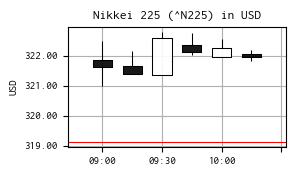

In [66]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))

ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
print("前日終値（ドル換算）", lastclose / last_close_usd)
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()